In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import lightkurve as lk
import theano
import exoplanet as xo
import pymc3 as pm
import theano.tensor as tt
from scipy.signal import savgol_filter
import corner
from scipy import integrate
import pickle
from copy import copy, deepcopy

In [2]:
import xoflares
# from complexflarefinder import *

In [3]:
print(xo.__version__)
print(theano.__version__)
print(pm.__version__)
print(xoflares.__version__)

0.1.6
1.0.4
3.6
0.1.0


In [4]:
class Lightcurve():
    """
    A class designed to handle the day-to-day requirements for
    Kepler light curves, including removing DC offsets.

    Parameters
    ----------
    curve : string
       The file name for a light curves.
    """

    id = 0   # The TIC number of the star

    flux = np.array([])
    raw_flux = np.array([])
    time = np.array([])
    flux_error = np.array([])
    cadenceno = np.array([])

    running_median_dt = 0
    running_median_fit = np.array([])
    datagap = False

    def __init__(self, curve=None, maxgap=1):

        flux = None
        flux = np.array([])
        if curve != None:
            self.add_data(curve=curve, maxgap=1)

    def __str__(self):
        return "<bayesflare Lightcurve for TIC "+str(self.id)+">"

    def __unicode__(self):
        return self.__str__()

    def __repr__(self):
        return self.__str__()

    def identity_string(self):
        """
        Returns a string which identifies the lightcurve.

        Returns
        -------
        str
           An identifier of the light curve based on its lengt.
        """
        return "lc_len_"+str(len(self.flux))

    def dt(self):
        """
        Calculate the sample separation for the light curve.

        Returns
        -------
        float
           The separation time for data in the light curve.
        """
        return self.time[1] - self.time[0]

    def fs(self):
        """
        Calculate the sample frequency of the light curve.

        Returns
        -------
        float
           The sample frequency of the light curve.
        """
        return 1.0 / self.dt()

    def psd(self):
        """
        Calculate the one-sided non-windowed power spectrum of the light curve. This uses the
        :func:`matplotlib.mlab.psd` function for computing the power spectrum, with a single
        non-overlapping FFT.

        Returns
        -------
        sk : array-like
           The Power spectral density of the light curve.
        f  : array-like
           An array of the frequencies.
        """
        l = len(self.flux)

        # get the power spectrum of the lightcurve data
        sk, f = ml.psd(x=self.flux, window=signal.boxcar(l), noverlap=0, NFFT=l, Fs=self.fs(), sides='onesided')

        # return power spectral density and array of frequencies
        return sk, f

    def smooth(self,f,window=101,polyorder=3):
        """
        Smooth lightcurve w Savitzy-Golay filter

        Parameters
        -------
            f: the flux array
            window: window to smooth over
            polyorder: order of the polynomial fit

        Returns
        -------
        float
           The separation time for data in the light curve.
        """

        smooth = savgol_filter(f, window, polyorder=3)
        resid = f - smooth
        mask = resid < 2*np.sqrt(np.mean(resid**2))

        return smooth, resid, mask


    def add_data(self, target=None, maxgap=1):
        """
        Add light curve data to the object..

        Parameters
        ----------
        curvefile : string
           The file path file pointing to a light curve fits files.
        maxgap : int, optional, default+1
           The largest gap size (in bins) allowed before the light curve is deemed to contain gaps.

        Exceptions
        ----------
        NameError
           This needs to be replaced with an exception specific to the package!
           Error is raised if there is an I/O error while accessing a light curve file.
        """
#         if curve == None:
#             raise NameError("[Error] No light curve file given")

        try:
#            dcurve = pyfits.open(curve)

            lcf = lk.search_lightcurvefile(target).download(quality_bitmask='none')
            lc = lcf.get_lightcurve('PDCSAP_FLUX').remove_nans().normalize()

            raw_flux = lc.flux -1

            time = lc.time*24*3600 # convert to seconds
            flux = lc.flux - 1
            m = np.isfinite(time) * np.isfinite(flux)
            time = lc.time[m]*24*3600
            flux = lc.flux[m] - 1

            m = np.isfinite(time) * np.isfinite(flux)
            count = 0
            for i in range(10):
                y_prime = np.interp(time, time[m], flux[m])
                smooth = savgol_filter(y_prime,101, polyorder=2)
                resid = flux - smooth
                sigma = np.sqrt(np.mean(resid**2))
                m0 = resid < sigma
                if m.sum() == m0.sum():
                    m = m0
                    break
                m = m0
                count+=1
            print(count, 'savgol count')


            flux = resid
            flux_error = lc.flux_err
            cadenceno = lc.cadenceno



        except IOError:
            raise NameError("[Error] opening file")

        self.flux = np.append(self.flux, deepcopy(flux))
        self.raw_flux = np.append(self.raw_flux, deepcopy(raw_flux))
        self.time = np.append(self.time, deepcopy(time))
        self.flux_error = np.append(self.flux_error, deepcopy(flux_error))
        self.cadenceno = np.append(self.cadenceno, deepcopy(cadenceno))
        self.datagap = self.gap_checker(self.flux, maxgap=maxgap)
        self.interpolate()

    def gap_checker(self, d, maxgap=1):
        """
        Check for NaN gaps in the data greater than a given value.

        Parameters
        ----------
        d : :class:`numpy.ndarray`
           The array to check for gaps in the data.

        maxgap : int, optional, default: 1
           The maximum allowed size of gaps in the data.

        Returns
        -------
        bool
           ``True`` if there is a gap of maxgap or greater exists in ``d``, otherwise ``False``.
        """

        z = np.invert(np.isnan(d))
        y = np.diff(z.nonzero()[0])
        if len(y < maxgap+1) != len(y):
            return True
        else:
            return False

    def nan_helper(self, y):
        """
        Helper to handle indices and logical indices of NaNs.

        Parameters
        ----------
        y : ndarray
           An array which may contain NaN values.

        Returns
        -------
        nans : ndarray
          An array containing the indices of NaNs
        index : function
          A function, to convert logical indices of NaNs to 'equivalent' indices

        Examples
        --------

           >>> # linear interpolation of NaNs
           >>> spam = np.ones(100)
           >>> spam[10] = np.nan
           >>> camelot = bf.Lightcurve(curves)
           >>> nans, x = camelot.nan_helper(spam)
           >>> spam[nans]= np.interp(x(nans), x(~nans), spam[~nans])


        """

        return np.isnan(y), lambda z: z.nonzero()[0]

    def interpolate(self):
        """
        A method for interpolating the light curves, to compensate for NaN values.

        Examples
        --------

           >>> camelot = bf.Lightcurve(curves)
           >>> camelot.interpolate()

        """

        z = self.flux
        nans, za= self.nan_helper(z)
        z[nans]= np.interp(za(nans), za(~nans), z[~nans]).astype('float32')
        self.flux = z


    def plot(self, figsize=(10,3)):
        """
        Method to produce a plot of the light curve.

        Parameters
        ----------
        figsize : tuple
           The size of the output plot.

        """
        fig, ax = plt.subplots(1)
        plt.title('Lightcurve for TIC'+str(self.id))
        self.trace = ax.plot(self.time/(24*3600.0), self.flux)
        fig.autofmt_xdate()
        plt.xlabel('Time [days]')
        plt.ylabel('Luminosity')
        plt.show()

In [5]:
l = Lightcurve()
l.add_data('AU Mic')

5 savgol count


In [6]:
complex_start = [866, 986, 994, 1817, 2130, 2419, 2817, 2822, 2846, 3355, 3364, 3565, 3573, 3824, 4536, 4541, 5808, 5829, 5969, 6114, 6134, 6652, 6821, 6930, 7202, 8050, 8150, 9002, 9007, 9110, 9117, 9166, 9205, 9249, 9256, 11956, 11962, 13241, 13362, 13379, 13843, 13868, 14056, 14067, 14072, 14702, 14707, 15219, 15225, 15337, 15340, 15350, 15355, 15471, 15775, 15856, 15877, 15925, 16011, 16049]
complex_stop = [986, 994, 1069, 1819, 2332, 2421, 2822, 2846, 2900, 3364, 3379, 3573, 3592, 3825, 4541, 4546, 5829, 5969, 6065, 6134, 6158, 6821, 6930, 7065, 7241, 8150, 8225, 9005, 9010, 9117, 9166, 9205, 9249, 9256, 9277, 11962, 11971, 13362, 13379, 13424, 13868, 13903, 14067, 14072, 14151, 14707, 14720, 15225, 15240, 15340, 15350, 15355, 15371, 15472, 15856, 15877, 15925, 16011, 16049, 16115]
complex_peaks = [983, 990, 1001, 1817, 2254, 2420, 2820, 2827, 2867, 3362, 3366, 3571, 3576, 3824, 4538, 4542, 5826, 5967, 5971, 6132, 6135, 6819, 6823, 6978, 7220, 8117, 8173, 9003, 9008, 9116, 9163, 9204, 9209, 9255, 9259, 11960, 11964, 13292, 13376, 13385, 13865, 13870, 14065, 14071, 14103, 14705, 14710, 15223, 15229, 15338, 15348, 15353, 15365, 15472, 15853, 15858, 15888, 15946, 16047, 16054]

[  983   990  1001  1817  2254  2420  2820  2827  2867  3362  3366  3571
  3576  3824  4538  4542  5826  5967  5971  6132  6135  6819  6823  6978
  7220  8117  8173  9003  9008  9116  9163  9204  9209  9255  9259 11960
 11964 13292 13376 13385 13865 13870 14065 14071 14103 14705 14710 15223
 15229 15338 15348 15353 15365 15472 15853 15858 15888 15946 16047 16054] 60


(114506043.08565693, 116913678.22953981)

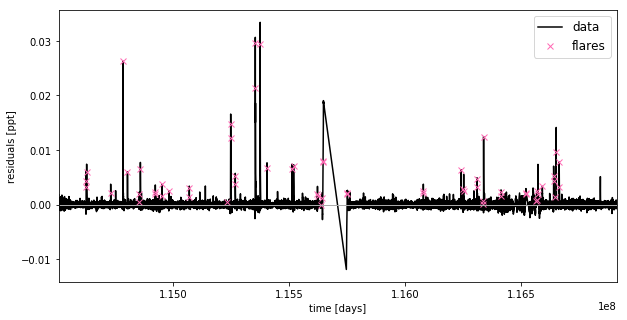

In [7]:
peaks = np.asarray(complex_peaks)
    
print(peaks, len(peaks))

peaks +=1

amp = l.flux[peaks]

plt.figure(figsize=(10, 5))
plt.plot(l.time, l.flux, "k", label="data")
plt.plot(l.time[peaks], l.flux[peaks], "x", color = "hotpink", label="flares")
plt.axhline(0, color="#aaaaaa", lw=1)
plt.ylabel("residuals [ppt]")
plt.xlabel("time [days]")
plt.legend(fontsize=12, loc=1)
plt.xlim(l.time.min(), l.time.max())

In [8]:
texp = 0.001388888888888889
ref_time = 0.5 * (l.time.min() + l.time.max())
cads = l.cadenceno - l.cadenceno[0]
x = l.time/(24*3600.0) #- ref_time
y = l.flux #  we're working with the data with a savgol subtracted

#number of points within each flare
npts = []

for i,j in zip(range(len(complex_start)), range(len(complex_stop))):
    k = complex_stop[j] - complex_start[i]
    npts.append(k)

tpeaks = x[peaks]
ampls = amp
fwhms = np.asarray(npts) * (2/1440)
npeaks = len(complex_peaks)

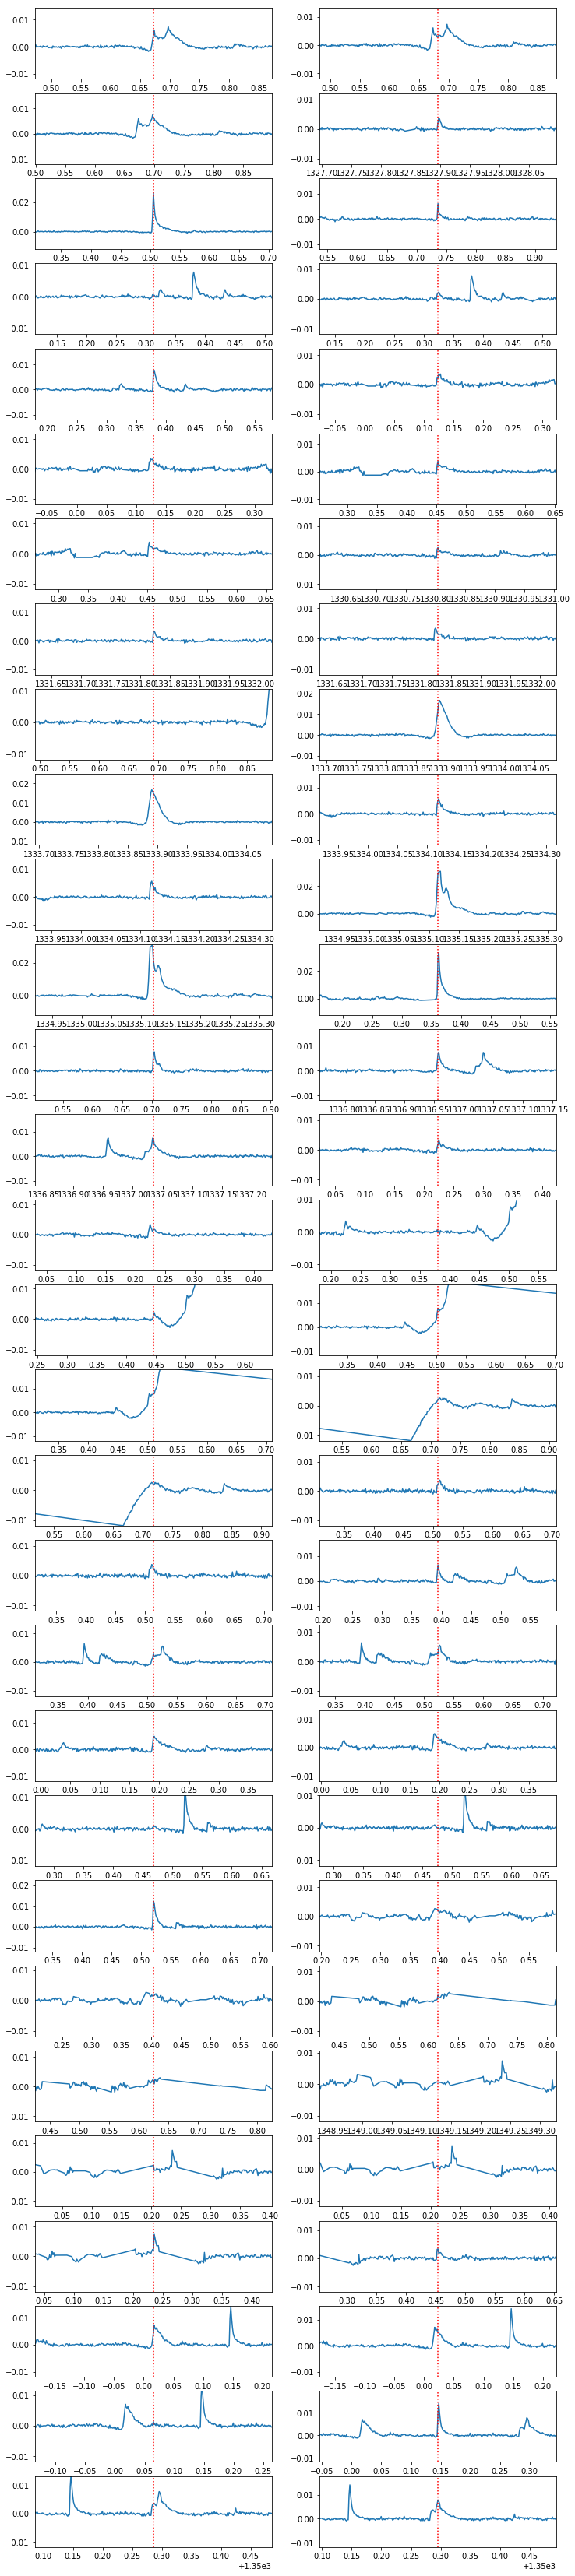

In [9]:
fig, axes = plt.subplots(ncols=2, nrows=np.ceil(npeaks/2).astype(int), figsize=[12,npeaks])
axes = axes.flatten()
for i in range(npeaks):
    ax = axes[i]
    ax.plot(x, y)
    ax.axvline(tpeaks[i], 0, 1, color='r', linestyle=':')
    ax.set_xlim(tpeaks[i]-0.2, tpeaks[i]+0.2)
    ax.set_ylim(np.min(y), np.max(ampls[i]+.010))

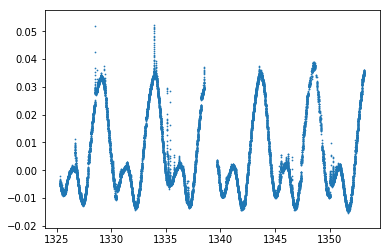

In [10]:
# determine the rotation period of the star
y = l.raw_flux
yerr = l.flux_error

plt.scatter(x,y,s=.5)

Text(0, 0.5, 'power')

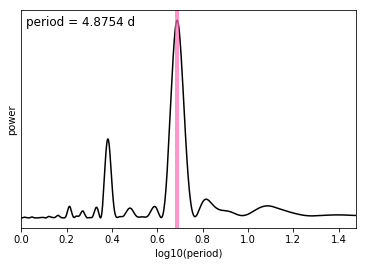

In [11]:
results = xo.estimators.lomb_scargle_estimator(
    x, y, max_peaks=1, min_period=1.0, max_period=30.0,
    samples_per_peak=50)

peak = results["peaks"][0]
ls_period = peak["period"]
freq, power = results["periodogram"]
plt.plot(-np.log10(freq), power, "k")
plt.axvline(np.log10(ls_period), color="hotpink", lw=4, alpha=0.7)
plt.xlim((-np.log10(freq)).min(), (-np.log10(freq)).max())
plt.annotate("period = {0:.4f} d".format(ls_period),
             (0, 1), xycoords="axes fraction",
             xytext=(5, -5), textcoords="offset points",
             va="top", ha="left", fontsize=12)
plt.yticks([])
plt.xlabel("log10(period)")
plt.ylabel("power")

In [12]:
# GP model for smoothing using above period
def build_model(mask=None, start=None):
    if mask is None:
        mask = np.ones_like(x, dtype=bool)
    with pm.Model() as model:

        # The mean flux of the time series
        mean = pm.Normal("mean", mu=0, sd=.015) ###changed

        # A jitter term describing excess white noise
        logs2 = pm.Normal("logs2", mu=2*np.log(np.min(yerr[mask])), sd=.005) ###changed

        # A SHO term to capture long term trends
        logS = pm.Normal("logS", mu=0.0, sd=15.0, testval=np.log(np.var(y[mask])))
        logw = pm.Normal("logw", mu=np.log(2*np.pi/10.0), sd=10.0)
        term1 = xo.gp.terms.SHOTerm(log_S0=logS, log_w0=logw, Q=1/np.sqrt(2))
        
        # The parameters of the RotationTerm kernel
        logamp = pm.Normal("logamp", mu=np.log(np.var(y[mask])), sd=.005) ###changed
        logperiod = pm.Normal("logperiod", mu=np.log(ls_period), sd=0.2)
        period = pm.Deterministic("period", tt.exp(logperiod))
        logQ0 = pm.Normal("logQ0", mu=1.0, sd=10.0)
        logdeltaQ = pm.Normal("logdeltaQ", mu=2.0, sd=10.0)
        mix = pm.Uniform("mix", lower=0, upper=1.0)
        term2 = xo.gp.terms.RotationTerm(
            log_amp=logamp,
            period=period,
            log_Q0=logQ0,
            log_deltaQ=logdeltaQ,
            mix=mix
        )

        tpeak = pm.Normal("tpeak", mu=tpeaks, sd=np.ones_like(tpeaks) * 0.003,
                      testval=tpeaks, shape=npeaks)
        logFwhm = pm.Normal("logFwhm", mu=np.log(fwhms), sd=1.0, testval=np.log(fwhms),
                        shape=npeaks)
        logAmpl = pm.Normal("logAmpl", mu=np.log(ampls), sd=1.0, testval=np.log(ampls),
                        shape=npeaks)
        fwhm = pm.Deterministic("fwhm", tt.exp(logFwhm))
        ampl = pm.Deterministic("ampl", tt.exp(logAmpl))
        
        light_curve = xoflares.get_light_curve(x[mask], tpeak, fwhm, ampl, texp=texp, oversample=9)
        pm.Deterministic("light_curve", light_curve)
        model.light_curves = light_curve

        # Set up the Gaussian Process model
        kernel = term1 + term2
        gp = xo.gp.GP(kernel, x[mask], yerr[mask]**2 + tt.exp(logs2), J=6)

        # Compute the Gaussian Process likelihood and add it into the
        # the PyMC3 model as a "potential"
        pm.Potential("loglike", gp.log_likelihood(y[mask] - mean - light_curve))

        # Compute the mean model prediction for plotting purposes
        pm.Deterministic("pred", gp.predict())

        # Optimize to find the maximum a posteriori parameters
        if start is None:
            start = model.test_point
        map_soln = xo.optimize(start=start, vars=[mean, logs2])
        map_soln = xo.optimize(start=map_soln, vars=[mean, logs2, logS, logw])
        map_soln = xo.optimize(start=map_soln, vars=[fwhm, mean])
        map_soln = xo.optimize(start=map_soln, vars=[ampl, mean])
        map_soln = xo.optimize(start=map_soln, vars=[fwhm, ampl])
        map_soln = xo.optimize(start=map_soln, vars=[tpeak])
        map_soln = xo.optimize(start=map_soln, vars=[mean, logs2, logamp, logQ0, logdeltaQ, mix])
        map_soln = xo.optimize(start=map_soln, vars=[mean, logs2])
        map_soln = xo.optimize(start=map_soln, vars=[mean, logs2, logS, logw])
        map_soln = xo.optimize(start=map_soln, vars=[fwhm, mean])
        map_soln = xo.optimize(start=map_soln, vars=[ampl, mean])
        map_soln = xo.optimize(start=map_soln, vars=[fwhm, ampl])
        map_soln = xo.optimize(start=map_soln, vars=[tpeak])
        map_soln = xo.optimize(start=map_soln, vars=[tpeak,fwhm, ampl])
    return model, map_soln

model0, map_soln0 = build_model()

/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[t

optimizing logp for variables: ['logs2', 'mean']


/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]
/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]

message: Optimization terminated successfully.
logp: 59249.731987612664 -> 66998.0910544518
optimizing logp for variables: ['logw', 'logS', 'logs2', 'mean']


/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]
/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]

message: Desired error not necessarily achieved due to precision loss.
logp: 66998.0910544518 -> 107298.95327423833


/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]
/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]

optimizing logp for variables: ['mean', 'logFwhm']


/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]
/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]

message: Desired error not necessarily achieved due to precision loss.
logp: 107298.95327423833 -> 108725.48016049502
optimizing logp for variables: ['mean', 'logAmpl']


/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]
/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]

message: Desired error not necessarily achieved due to precision loss.
logp: 108725.48016049502 -> 108844.51767642712
optimizing logp for variables: ['logAmpl', 'logFwhm']


/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]
/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]

message: Desired error not necessarily achieved due to precision loss.
logp: 108844.51767642712 -> 110924.37351187582


/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]
/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


optimizing logp for variables: ['tpeak']


/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]
/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]

message: Desired error not necessarily achieved due to precision loss.
logp: 110924.37351187582 -> 111354.50499205457
optimizing logp for variables: ['mix_interval__', 'logdeltaQ', 'logQ0', 'logamp', 'logs2', 'mean']


/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]
/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]

message: Desired error not necessarily achieved due to precision loss.
logp: 111354.50499205457 -> 111402.58288270065
optimizing logp for variables: ['logs2', 'mean']


/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]
/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]

message: Desired error not necessarily achieved due to precision loss.
logp: 111402.58288270065 -> 111402.58288270065
optimizing logp for variables: ['logw', 'logS', 'logs2', 'mean']


/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]
/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]

message: Desired error not necessarily achieved due to precision loss.
logp: 111402.58288270065 -> 113653.00498002343
optimizing logp for variables: ['mean', 'logFwhm']


/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]
/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]

message: Desired error not necessarily achieved due to precision loss.
logp: 113653.00498002343 -> 113938.92512583417
optimizing logp for variables: ['mean', 'logAmpl']


/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]
/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]

message: Desired error not necessarily achieved due to precision loss.
logp: 113938.92512583417 -> 114263.17443358859
optimizing logp for variables: ['logAmpl', 'logFwhm']


/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]
/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]

message: Desired error not necessarily achieved due to precision loss.
logp: 114263.17443358859 -> 114301.20793629685
optimizing logp for variables: ['tpeak']


/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]
/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]

message: Desired error not necessarily achieved due to precision loss.
logp: 114301.20793629685 -> 114507.91962674612
optimizing logp for variables: ['logAmpl', 'logFwhm', 'tpeak']


/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]
/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]

message: Desired error not necessarily achieved due to precision loss.
logp: 114507.91962674612 -> 114526.9300496604


/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]


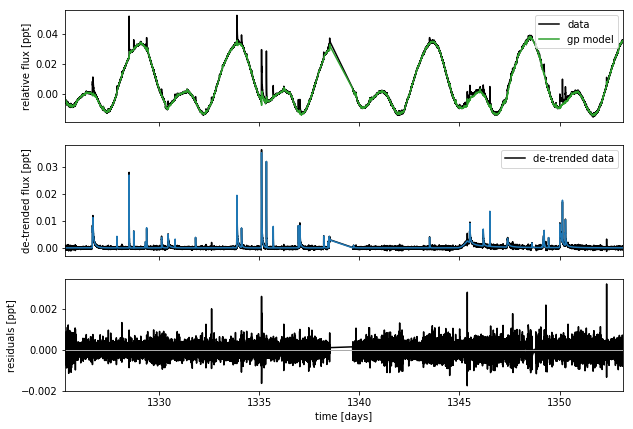

In [13]:
# plot the results of the model fitting + smoothing

def plot_light_curve(model, soln, mask=None):
    if mask is None:
        mask = np.ones(len(x), dtype=bool)

    fig, axes = plt.subplots(3, 1, figsize=(10, 7), sharex=True)

    ax = axes[0]
    ax.plot(x[mask], y[mask], "k", label="data")
    gp_mod = xo.utils.eval_in_model(model.pred, soln, model=model)
    gp_mod += soln["mean"]
    ax.plot(x[mask], gp_mod, color="C2", label="gp model")
    ax.legend(fontsize=10)
    ax.set_ylabel("relative flux [ppt]")

    ax = axes[1]
    ax.plot(x[mask], y[mask] - gp_mod, "k", label="de-trended data")
    light_curve = xo.utils.eval_in_model(model.light_curves, soln, model=model)

    mod = light_curve
    ax.plot(x[mask], mod,)
    ax.legend(fontsize=10)
    ax.set_ylabel("de-trended flux [ppt]")

    ax = axes[2]
    mod = gp_mod + light_curve
    ax.plot(x[mask], y[mask] - mod, "k")
    ax.axhline(0, color="#aaaaaa", lw=1)
    ax.set_ylabel("residuals [ppt]")
    ax.set_xlim(x[mask].min(), x[mask].max())
    ax.set_xlabel("time [days]")
    
    return fig
    
plot_light_curve(model0, map_soln0);

In [ ]:
# subtract off the model to get residual (flatten light curve w/ spots/rotation removed)

mod = map_soln0["pred"] + map_soln0["mean"] + map_soln0["light_curve"]
resid = y - mod
rms = np.sqrt(np.median(resid**2))
mask = np.abs(resid) < 5 * rms

plt.figure(figsize=(10, 5))
plt.plot(x, resid, "k", label="data")
plt.plot(x[~mask], resid[~mask], "xr", label="outliers")
plt.axhline(0, color="#aaaaaa", lw=1)
plt.ylabel("residuals [ppt]")
plt.xlabel("time [days]")
plt.legend(fontsize=12, loc=3)
plt.xlim(x.min(), x.max());

In [ ]:

model, map_soln1 = build_model(mask=None, start=map_soln0)
fig = plot_light_curve(model, map_soln1, mask=None)

In [ ]:
with model:
    map_soln2 = xo.optimize(start=map_soln1,)


In [ ]:
with model:
    mean_field = pm.fit(method='advi', start=map_soln2,  n=100000)

In [ ]:
with model:
    trace = mean_field.sample(3000)

In [ ]:
fig, axes = plt.subplots(1,1, figsize=[4, 4])
ax = axes
ax.hist( trace['period'], bins=20, histtype='step', color="k")
plt.yticks([])

ax.set_xlabel("rotation period [days]")
ax.set_ylabel("posterior density");

plt.tight_layout()
fig.savefig('aumic-rotation.png', dpi=200)
q = np.percentile(trace['period'], [16,50,84])
print('Prot = {} +{} - {}'.format(q[1], q[2] - q[1], q[1]-q[0]))


In [ ]:
fig, axes = plt.subplots(3, 1, figsize=(14, 7), sharex=True)

ax = axes[0]
ax.plot(x, y, ".k", label="data", ms=1)
gp_mod = np.median(trace['pred'], axis=0)
gp_mod += np.median(trace["mean"])
ax.plot(x, gp_mod, color="C2", label="gp model")
ax.legend(fontsize=12)
ax.set_ylabel("relative flux [ppt]", fontsize=12)

ax = axes[1]
ax.plot(x, y - gp_mod, ".k", label="de-trended data", ms=1)
light_curve = np.median(trace['light_curve'], axis=0)

mod = light_curve
ax.plot(x, mod, label='flare model')
ax.legend(fontsize=12)
ax.set_ylabel("de-trended flux [ppt]", fontsize=12)

ax = axes[2]
# mod = gp_mod + light_curve
# ax.plot(x, y - mod, "k")
# ax.axhline(0, color="#aaaaaa", lw=1)
# ax.set_ylabel("residuals [ppt]", fontsize=12)
ax.plot(x, y - gp_mod, ".k", label="de-trended data", ms=1)
ax.plot(x, mod, label='flare model')

ax.legend(fontsize=12)#, loc=3, ncol=2)
ax.set_ylabel("de-trended flux [ppt]", fontsize=12)
#ax.set_ylim(-5,6)

#ax.set_xlim(x.min(), 1336)
#ax.set_xlim(0,10)
ax.set_xlabel("time [days]", fontsize=12)

plt.tight_layout()

In [ ]:
fig, axes = plt.subplots(3, 1, figsize=(14, 7), sharex=True)

ax = axes[0]
ax.plot(x, y, ".k", label="data", ms=1)
gp_mod = np.median(trace['pred'], axis=0)
gp_mod += np.median(trace["mean"])
ax.plot(x, gp_mod, color="C2", label="gp model")
ax.legend(fontsize=12)
ax.set_ylabel("relative flux [ppt]", fontsize=12)

ax = axes[1]
ax.plot(x, y - gp_mod, ".k", label="de-trended data", ms=1)
light_curve = np.median(trace['light_curve'], axis=0)

mod = light_curve
ax.plot(x, mod, label='flare model')
ax.legend(fontsize=12)
ax.set_ylabel("de-trended flux [ppt]", fontsize=12)

ax = axes[2]
# mod = gp_mod + light_curve
# ax.plot(x, y - mod, "k")
# ax.axhline(0, color="#aaaaaa", lw=1)
# ax.set_ylabel("residuals [ppt]", fontsize=12)
ax.plot(x, y - gp_mod, ".k", label="de-trended data", ms=1)
ax.plot(x, mod, label='flare model')

ax.legend(fontsize=12)#, loc=3, ncol=2)
ax.set_ylabel("de-trended flux [ppt]", fontsize=12)
ax.set_ylim(-.005,.005)

ax.set_xlim(x.min(), 1336)
#ax.set_xlim(0,10)
ax.set_xlabel("time [days]", fontsize=12)

plt.tight_layout()

In [ ]:
flc =  np.percentile(trace['light_curve'], [16, 50, 84], axis=0)
fig, axes = plt.subplots(ncols=2, nrows=np.ceil(npeaks/2).astype(int), figsize=[12,npeaks*2])
axes = axes.flatten()
for i in range(npeaks):
    timemask = (x >= tpeaks[i]-0.05) * (x < tpeaks[i]+0.05)
    ax = axes[i]
    ax.plot(x[timemask], y[timemask]-gp_mod[timemask], '.k')
    ax.plot(x[timemask], flc[1][timemask], color="hotpink", label="model")
    art = ax.fill_between(x[timemask], flc[0][timemask],
                          flc[2][timemask], color="hotpink", alpha=0.3,
                               zorder=1000)
    art.set_edgecolor("none")
    ax.set_xlim(tpeaks[i]-0.05, tpeaks[i]+0.05)
    ax.set_ylim(np.min(y[timemask]-gp_mod[timemask]) - .001, .4*np.max(y[timemask]-gp_mod[timemask]) + np.max(y[timemask]-gp_mod[timemask]))
    ax.legend()
    

    fig.tight_layout()

In [ ]:
def multiflaremodelnp(time, tpeaks, fwhms, ampls):
    time = np.asarray(time, dtype=float)
    tpeaks = np.atleast_1d(tpeaks)
    fwhms = np.atleast_1d(fwhms)
    ampls = np.atleast_1d(ampls)
    multiflare_lc = np.zeros_like(time)
    npeaks = tpeaks.shape[0]
    for i in range(npeaks):
        flare_lc = _flaremodelnp(time, tpeaks[i], fwhms[i], ampls[i])
        multiflare_lc = multiflare_lc + flare_lc
    return multiflare_lc


def get_light_curvenp(time, tpeaks, fwhms, ampls, texp=None, oversample=7):
    time = np.asarray(time, dtype=float)

    tpeaks = np.atleast_1d(tpeaks)
    fwhms = np.atleast_1d(fwhms)
    ampls = np.atleast_1d(ampls)
    print(tpeaks, 'tpeaks')
    print(fwhms,'fwhms')
    print(ampls, 'ampls')

    if texp is None:
        tgrid = time
    if texp is not None:
        # taking this oversample code from
        # https://github.com/dfm/exoplanet
        # and https://github.com/lkreidberg/batman
        texp = float(texp)
        oversample = int(oversample)
        oversample += 1 - oversample % 2
        dt = np.linspace(-texp / 2., texp / 2.,
                         oversample)
        tgrid = (dt + time.reshape(time.size, 1)).flatten()

    multiflare_lc = multiflaremodelnp(tgrid, tpeaks, fwhms, ampls)

    if texp is not None:
        multiflare_lc = np.mean(
            multiflare_lc.reshape(-1, oversample),
            axis=1)

    return multiflare_lc

def _flaremodelnp(time, tpeak, fwhm, ampl):
    # reuses some code from AltaiPony and Apaloosa
    _fr = [1.00000, 1.94053, -0.175084, -2.24588, -1.12498]
    _fd = [0.689008, -1.60053, 0.302963, -0.278318]
    flare_lc = np.zeros_like(time)
    flare_lc = np.where((time <= tpeak) * ((time - tpeak) / fwhm > -1.),
                        (_fr[0] +
                         _fr[1] * ((time - tpeak) / fwhm) +
                         _fr[2] * ((time - tpeak) / fwhm)**2. +
                         _fr[3] * ((time - tpeak) / fwhm)**3. +
                         _fr[4] * ((time - tpeak) / fwhm)**4.) *
                        ampl,
                        flare_lc
                        )
    flare_lc = np.where((time > tpeak) * ((time - tpeak) / fwhm < 20.),
                        (_fd[0] * np.exp(((time - tpeak) / fwhm) * _fd[1]) +
                         _fd[2] * np.exp(((time - tpeak) / fwhm) * _fd[3])) *
                        ampl,
                        flare_lc
                        )
    return flare_lc

In [ ]:
def get_flare_integral(time, tpeak, fwhm, ampl, texp=None, oversample=7):
    """
    calculates the integral of flares. Useful for calculating
    equivalent width and energy
    this is designed to be a post processing step, not run within the
    HMC model. This is mostly because it is slightly awkward to implement
    and integral in theano
    """
    feval = get_light_curvenp(time,
                              tpeak,
                              fwhm,
                              ampl,
                              texp,
                              oversample)

    plt.scatter(time,feval)
    plt.show()
    integral = np.trapz(feval, time)

    return integral

In [ ]:
# filename = 'AU_Mic_flare_results_complex'
# outfile = open(filename,'wb')
# pickle.dump([x, y, peaks], outfile)
# outfile.close()

In [ ]:
# filename = 'AU_Mic_flare_results_trace_complex'
# outfile = open(filename,'wb')
# pickle.dump(trace, outfile)
# outfile.close()

In [ ]:
# trace = pickle.load(open('AU_Mic_flare_results_trace_complex', 'rb'))
# x, y, peaks = pickle.load(open('AU_Mic_flare_results_complex', 'rb'))

In [ ]:
print(len(trace['ampl'][:,0]))

In [ ]:
len(trace[0])
for i in range(len(trace[0])):
    amp_0 = np.median(trace['ampl'][:,i])

In [ ]:
energy = []
energy_err = []

for i in range(len(peaks)):
    e = get_flare_integral(x,
                           np.median(trace['tpeak'][:,i]),np.median(trace['fwhm'][:,i]),
                           np.median((trace['ampl'][:,i])))
    energy.append(e)

In [ ]:
int_energy = np.sort(np.asarray(energy))
print(energy)
d = 3.0008e19 #distance in cm
ref_energy = 1.0577483864655743e-08
abs_energy = []
for i in range(len(energy)):
    abs = energy[i] * ref_energy * 4 * np.pi * (d)**2 
    abs_energy.append(abs)

In [ ]:
sort = np.sort(abs_energy)
print(sort)

In [ ]:
time_duration = (len(l.time)*2 / 60 / 24)
log_sort = np.log10(sort)
n_bins = len(log_sort)
counts, bin_edges = np.histogram(log_sort, bins=n_bins, normed=True)
cdf = np.cumsum(counts)

x_ffd = []
y_ffd= []
for i in range(len(log_sort)):
    x_ffd.append(log_sort[i])
    y_ffd.append(cdf[i]/time_duration)

x_ffd = x_ffd[::-1]
plt.yscale('log')
plt.scatter(x_ffd,y_ffd, c='hotpink',s=10)